In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
df = pd.read_csv("data/dataset.csv", sep=",")
df

,300,300.5,301,301.5,302,302.5,303,303.5,304,304.5,...,796,796.5,797,797.5,798,798.5,799,799.5,800,Species
0,0.572190,0.575590,0.578230,0.581840,0.583190,0.583880,0.584080,0.585820,0.586350,0.587990,...,-0.000472,-0.000208,-0.000239,-0.000046,0.000041,-0.000273,-0.000257,-0.000087,0,Chlorella sorokiniana
1,0.600400,0.603130,0.605350,0.605980,0.608120,0.608850,0.607940,0.606870,0.609300,0.608630,...,-0.000350,-0.000325,-0.000135,-0.000215,-0.000180,-0.000104,0.000056,0.000173,0,Chlorella sorokiniana
2,0.608230,0.611190,0.612230,0.612800,0.613240,0.613110,0.611900,0.611810,0.612940,0.613950,...,-0.000107,-0.000220,-0.000010,0.000170,0.000249,0.000217,0.000236,0.000204,0,Chlorella sorokiniana
3,0.653960,0.653370,0.649850,0.649430,0.646630,0.644270,0.643610,0.642940,0.640410,0.638760,...,0.001660,0.001890,0.002160,0.001990,0.001590,0.000590,0.000082,-0.000227,0,Chlorella sorokiniana
4,0.559990,0.557480,0.555720,0.557420,0.552390,0.551030,0.551530,0.549710,0.547410,0.550870,...,0.001670,0.001590,0.001870,0.001310,0.000815,0.000315,-0.000051,-0.000436,0,Chlorella sorokiniana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,3.522438,3.579758,3.637078,3.694399,3.751719,3.809039,3.866359,3.923679,3.981000,4.038320,...,-0.000608,-0.000532,-0.000456,-0.000380,-0.000304,-0.000228,-0.000152,-0.000076,0,Conticribra weissflogii
140,2.996147,3.050306,3.104465,3.158625,3.212784,3.266943,3.321102,3.375261,3.429421,3.483580,...,-0.014269,-0.012486,-0.010702,-0.008918,-0.007135,-0.005351,-0.003567,-0.001784,0,Conticribra weissflogii
141,4.092617,4.108738,4.124858,4.140978,4.157099,4.173219,4.189339,4.205459,4.221580,4.237700,...,-0.004089,-0.003578,-0.003067,-0.002556,-0.002045,-0.001533,-0.001022,-0.000511,0,Conticribra weissflogii
142,3.307386,3.335426,3.363465,3.391505,3.419544,3.447584,3.475624,3.503663,3.531703,3.559742,...,-0.004273,-0.003739,-0.003205,-0.002671,-0.002137,-0.001602,-0.001068,-0.000534,0,Conticribra weissflogii


In [3]:
n_features = len(df.columns) - 1

In [4]:
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

In [14]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
import numpy as np

In [6]:
def exponential_dilation(r): return lambda x: (1 - np.exp(-r*x))

In [7]:
def objective(trial):
    X_dilated = exponential_dilation(trial.suggest_float("dilation_coefficient",0,1))(X)
    kf = KFold(n_splits = 10, shuffle = True)
    n_pca_components = trial.suggest_int("pca_components", 3, 90)
    pca = PCA(n_components=n_pca_components)
    corr = []
    for ix_train, ix_test in kf.split(X_dilated):
        model = KNeighborsClassifier(n_neighbors=trial.suggest_int("n_neighbors",3,10), metric=trial.suggest_categorical("knn_metric",['minkowski', 'euclidean', 'cosine']))
        X_train, y_train = X[ix_train], y[ix_train]
        X_test, y_test = X[ix_test], y[ix_test]
        U_train = pca.fit_transform(X_train)
        U_test = pca.transform(X_test)
        model.fit(U_train, y_train)
        y_pred = model.predict(U_test)
        corr.append(matthews_corrcoef(y_test, y_pred))
    return np.mean(corr) - 0.01*n_pca_components

In [8]:
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
study = optuna.create_study(
    storage="sqlite:///data/optuna.sqlite",
    direction='maximize',
    study_name=f'KNN_with_PCA_timestamp_{timestamp}',
    load_if_exists=False
)
study.optimize(objective, n_trials = 100)

[I 2025-01-25 14:22:36,190] A new study created in RDB with name: KNN_with_PCA_timestamp_20250125142235
[I 2025-01-25 14:22:42,658] Trial 0 finished with value: 0.1979249203414375 and parameters: {'dilation_coefficient': 0.5169158445016894, 'pca_components': 73, 'n_neighbors': 9, 'knn_metric': 'euclidean'}. Best is trial 0 with value: 0.1979249203414375.
[I 2025-01-25 14:22:48,643] Trial 1 finished with value: 0.22048553944518312 and parameters: {'dilation_coefficient': 0.6407507805715834, 'pca_components': 69, 'n_neighbors': 8, 'knn_metric': 'minkowski'}. Best is trial 1 with value: 0.22048553944518312.
[I 2025-01-25 14:22:52,365] Trial 2 finished with value: 0.5755483779563586 and parameters: {'dilation_coefficient': 0.7913118115274508, 'pca_components': 41, 'n_neighbors': 3, 'knn_metric': 'euclidean'}. Best is trial 2 with value: 0.5755483779563586.
[I 2025-01-25 14:22:54,458] Trial 3 finished with value: 0.6406096724723468 and parameters: {'dilation_coefficient': 0.0127088122567099

In [9]:
study.best_params

{'dilation_coefficient': 0.6867147352484961,
 'pca_components': 5,
 'n_neighbors': 5,
 'knn_metric': 'cosine'}

In [10]:
pca = PCA(n_components=study.best_params['pca_components'])
X_transformed = exponential_dilation(study.best_params['dilation_coefficient'])(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, stratify=y)
U_train = pca.fit_transform(X_train)
U_test = pca.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=study.best_params['n_neighbors'], metric=study.best_params['knn_metric'])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
matthews_corrcoef(y_true=y_test,y_pred=y_pred)

np.float64(1.0)

In [15]:
confusion_matrix(y_true=y_test,y_pred=y_pred)

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]])

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
udf_train = pd.DataFrame(U_train)
udf_train['labels'] = y_train

<Figure size 640x480 with 0 Axes>

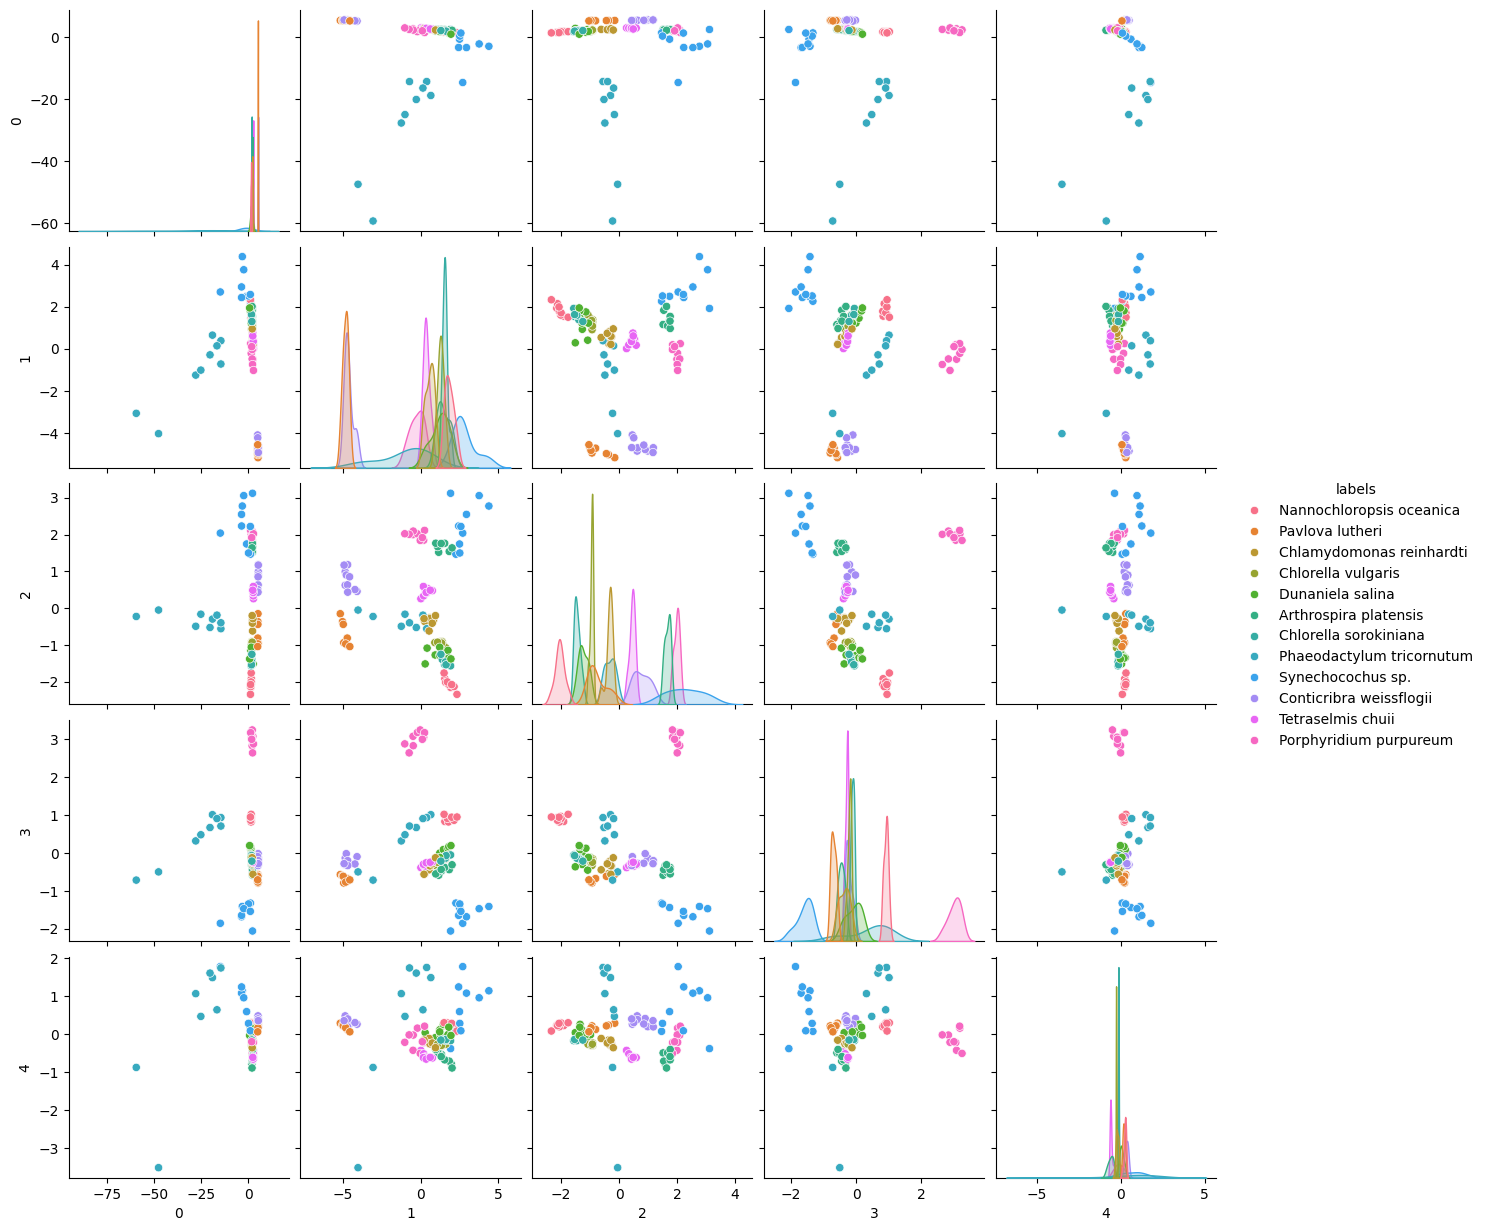

In [13]:
plt.figure()
sns.pairplot(udf_train, hue='labels')
plt.show()